In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 22

# Solving the skateboard problem numerically -- without the small angle approximation

In a previous activity, we learned about the Euler method to numerically solve an ODE -- but it only applies to a 1st order ODE. So we have to rewrite our 2nd order ODE
$$
\dot \phi = -\omega_0^2 \sin \phi
$$
to a system of two coupled 1st order ODEs by introducing $\omega = \dot \phi$:
\begin{eqnarray*}
\frac{d \phi}{dt} &=& \omega\\
\frac{d \omega}{dt} &=& -\omega_0^2 \sin \phi
\end{eqnarray*}

(This is the same as in the previous homework, the only difference being the added $\sin$, and adding it in the code is just about as easy.)

In [8]:
g = 9.8 # m/s^2
L = 5 # m
om0 = (g/L) ** .5
phi0 = 0.5 # initial angle

In [9]:
def f_omega(t, omega, phi): return -om0**2 * np.sin(phi) # Note the np.sin() is new
def f_phi(t, omega, phi): return omega

t = 0
omega = 0
phi = phi0
dt = 0.1
ts, omegas, phis = [t], [omega], [phi]
for n in range(200):
    omega += dt * f_omega(t, omega, phi)
    phi += dt * f_phi(t, omega, phi)
    t += dt
    ts.append(t)
    omegas.append(omega)
    phis.append(phi)

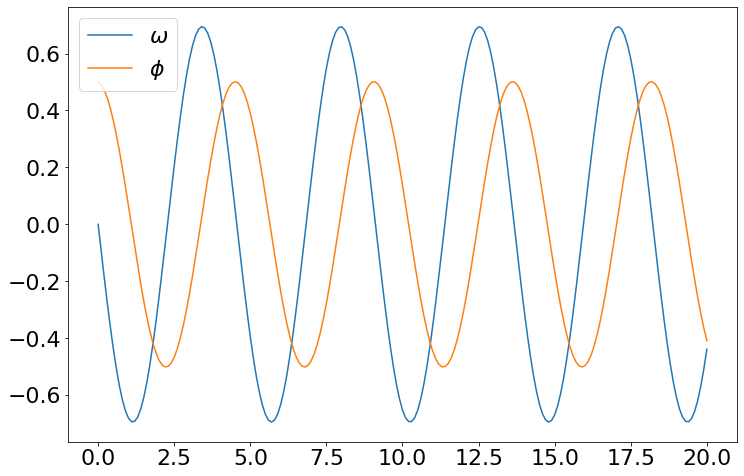

In [10]:
ts, omegas, phis = np.array(ts), np.array(omegas), np.array(phis)
plt.plot(ts, omegas, label="$\omega$")
plt.plot(ts, phis, label="$\phi$")
#plt.plot(ts, np.exp(-ts));
plt.legend();

And well, that worked quite nicely. In fact, too nicely, as I noticed in class, but I only realized the problem afterwards: When I update $\omega$ above, I'm using the r.h.s. based on the old $\omega$ and old $\phi$. But when I update $\phi$, I'm using the rhs based on the new $\omega$ and the old $\phi$. In the Euler method, I really should use the old values always.

What I ended up doing here, inadvertently is to implement some leap-frog type method, which is a bug. It's also a bug which actually makes this numerical integration a lot better than the Euler method ;)

## Doing the Euler method correctly

In [11]:
t = 0
omega = 0
phi = .1
dt = 0.1
ts, omegas, phis = [t], [omega], [phi]
for n in range(200):
    rhs_omega, rhs_phi = f_omega(t, omega, phi), f_phi(t, omega, phi)
    omega += dt * rhs_omega
    phi   += dt * rhs_phi
    t += dt
    ts.append(t)
    omegas.append(omega)
    phis.append(phi)

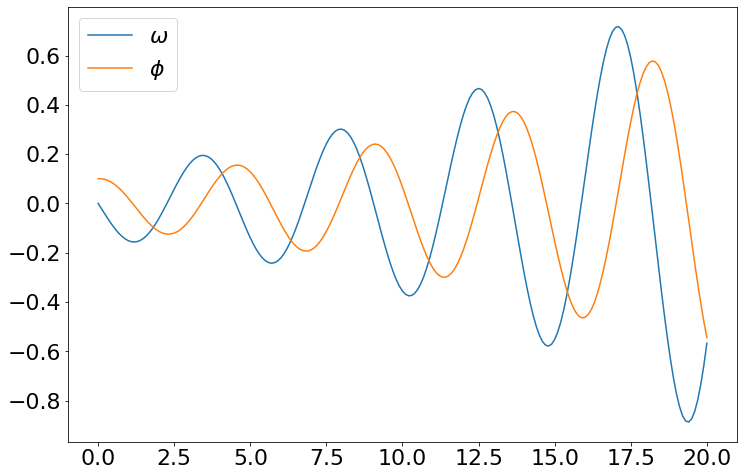

In [12]:
ts, omegas, phis = np.array(ts), np.array(omegas), np.array(phis)
plt.plot(ts, omegas, label="$\omega$")
plt.plot(ts, phis, label="$\phi$")
#plt.plot(ts, np.exp(-ts));
plt.legend();

So yeah, using the Euler method correctly, I have a bit of a problem -- It still captures the sinusoidal behavior correctly, but the amplitude keeps increasing over time, and that definitely doesn't make sense physically (where would the energy come from)? So what happens here is that this method has a substantial numerical error which keeps increasing over time. :(

## Coding things more nicely

The 2nd instance of the code above starts to hint that things could be done more nicely if one put $\omega$ and $\phi$ into a vector,
similary for the r.h.s., etc. That way one can have an Euler method that works for an arbitrary system of 1st order ODEs.

In [13]:
def euler(y0, f, dt, t_final):
    """
    Given the rhs function f(t, y) and initial condition y, uses the 
    Euler method to numerically integrate the ODE dy/dt = f(t, y) from
    0 to t_final using a timestep of dt
    """
    t = np.arange(0, t_final, dt)
    y = np.empty((len(y0), t.shape[0]))
    y[:,0] = y0
    for n in range(len(t)-1):
        rhs = np.asarray(f(t[n], y[:,n]))
        y[:,n+1] = y[:,n] + dt * rhs
    return t, y

Here, we specifically define our system of ODEs for the skateboard problem

In [14]:
# solution vector y = (omega, phi)
# rhs of the ODE we're solving
def f_skateboard(t, y):
    omega, phi = y
    return [-om0**2 * np.sin(phi), omega] # Again, note the added sin

# initial condition
y0 = [0, phi0]

We already now that the Euler method isn't doing great unless we use a pretty small timestep, so I'll just use $\Delta t = 0.001$ in the following.

Let's generalize our `integrate_and_plot()` function from last time to take an additional `phi_0` parameter:

In [24]:
def integrate_and_plot(dt, t_final, phi0):
    y0 = [0, phi0]
    t, y = euler(y0, f_skateboard, dt, t_final)
    plt.plot(t, y[1,:], '-o', label='numerical solution for $\phi$');
    plt.plot(t, phi0 * np.cos(om0 * t), label='analytical small-angle solution for $\phi$')
    plt.legend()

Let's start with $\phi_0 = 0.1$, which I'd say is pretty small, so the small angle approximation should do well -- and in fact, it does:

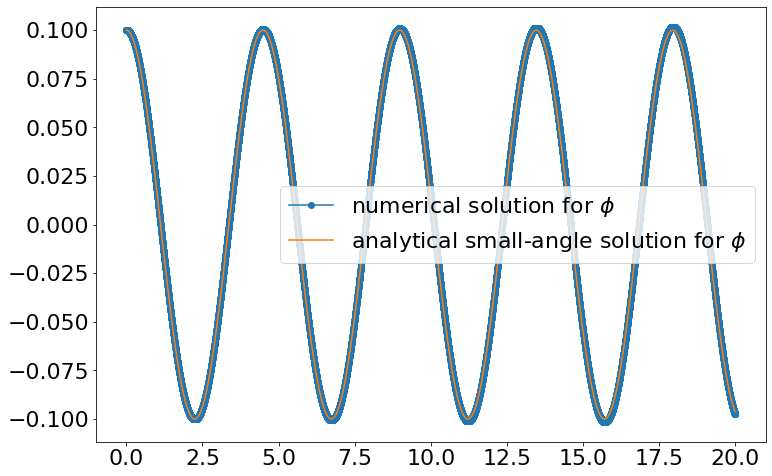

In [25]:
integrate_and_plot(dt=.001, t_final=20, phi0=.1)

Let's do it for $30$ degrees, which is somewhat small, but not real small. In this case, the solution still looks like a sine, but the frequency is a little bit smaller:

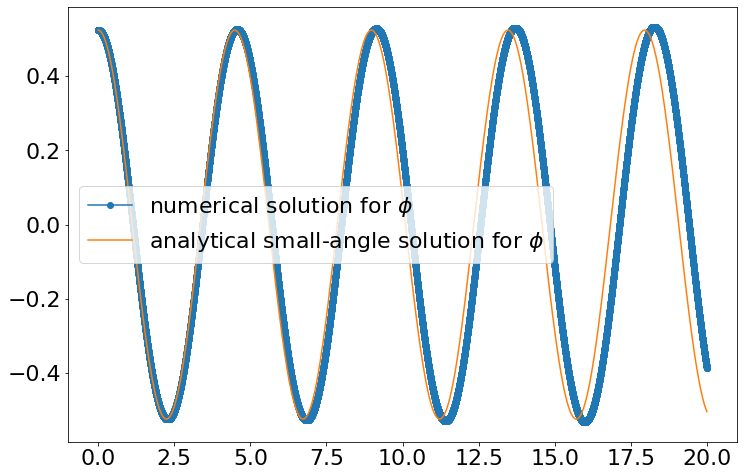

In [26]:
integrate_and_plot(dt=.001, t_final=20, phi0=30 * 2*np.pi/360)

Let's do 90 degrees. At that point, $\phi_0 = \pi/2 \approx 1.57$, while $\sin(\pi/2) = 1$, so the small angle approximation is definite off significantly. And that shows:

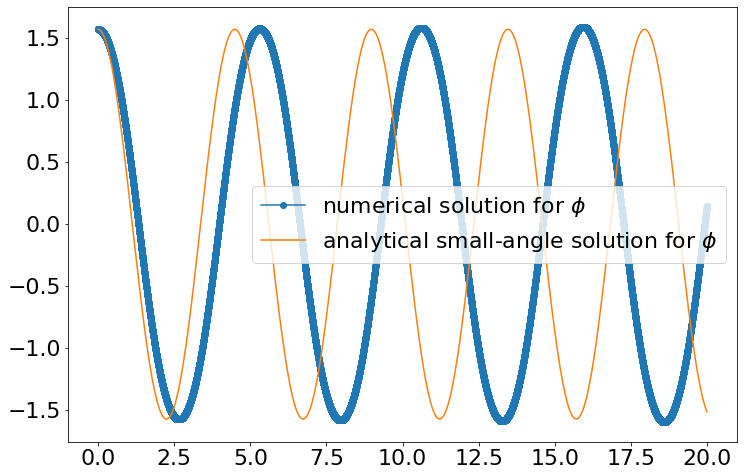

In [28]:
integrate_and_plot(dt=.001, t_final=20, phi0=90 * 2*np.pi/360)

Finally, we'll do 170 degrees -- this isn't really physical anymore for the problem of the skateboard, since the skateboard would just fall straight down rather than follow the circular path. But let's assume it's a roller coast, which is near the top of a loop. Not only is the frequency far off from the small angle case, we can also see that the solution doesn't really look like a sine anymore, it's flattened.

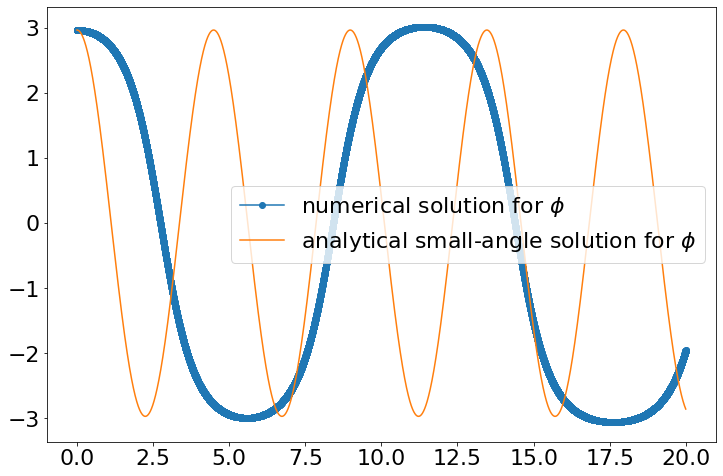

In [29]:
integrate_and_plot(dt=.001, t_final=20, phi0=170 * 2*np.pi/360)